# HW19
本次作业包括对PyTorch的简单练习和简单CNN模型的搭建，帮助大家熟悉PyTorch框架，截止时间为本周五2022.5.20 23：59。

# 1. PyTorch基础练习(3')
请注意，本题要求全部基于pytorch实现，不能使用pytorch的.tolist()或者.numpy()等函数将tensor转换成list或者numpy array来处理。

（1）首先，创建一个服从标准正态分布的$3\times 4$的tensor $A$，和一个服从标准正态分布的$2\times6$的tensor $B$(0.5')

In [2]:
import torch
A = torch.normal(0, 1, size=(3, 4), requires_grad=True)
B = torch.normal(0, 1, size=(2, 6), requires_grad=True)
A, B

(tensor([[ 0.8360,  1.1885,  0.4091, -0.3380],
         [-1.3274,  3.0550, -0.7050, -0.0658],
         [-1.7500,  0.6503,  1.1392, -0.2366]], requires_grad=True),
 tensor([[-0.9402,  0.8033,  0.0701,  0.0027,  1.3824, -1.2114],
         [-2.2931, -2.4131, -0.1651, -0.1384,  0.6314, -0.1873]],
        requires_grad=True))

（2）使用view操作将$B$的形状也转换成$3\times 4$，计算$A+B$和$AB^\top$（矩阵乘法）(0.5')

In [74]:
B = B.view((3, 4))
A+B, torch.mm(A, B.T)

(tensor([[-2.4638,  0.3747,  0.8200, -1.1299],
         [-0.5332, -1.1904, -1.9282, -0.3511],
         [ 0.0410,  0.1514, -0.3328,  0.2773]], grad_fn=<AddBackward0>),
 tensor([[-2.6103,  0.0725,  0.5387],
         [ 3.6323, -1.7039,  0.0168],
         [ 0.5843, -0.0422, -0.2333]], grad_fn=<MmBackward>))

（3）取出矩阵$A$的所有大于0的值，并按照行的顺序排列成一个一维的tensor $C$。(1')

例如：[[0, 0.1, 0.2], [-0.3, 0.4, -0.5]]需要转换成[0.1, 0.2, 0.4]

In [75]:
C = torch.masked_select(A, A.gt(0))
C

tensor([0.5739, 0.3185, 0.0097, 0.3349, 0.3891, 0.5677],
       grad_fn=<MaskedSelectBackward>)

（4）将$C$的每个元素平方，得到$D$。计算$D$的平均值$mean(D)$，并求出$mean(D)$对$A$的梯度(1')

In [76]:
D = C*C
E = torch.mean(D)
E.backward()
A.grad

tensor([[0.1913, 0.0000, 0.1062, 0.0000],
        [0.0000, 0.0032, 0.1116, 0.0000],
        [0.0000, 0.1297, 0.0000, 0.1892]])

# 2.神经网络拟合函数(3')

请使用torch.nn这一模块实现通过神经网络拟合函数的任务，利用4次多项式函数来拟合余弦函数（定义域：$[-\pi,\pi]$）。

请作图展示拟合后的效果。
同学们可以参考课件的代码完成。

In [82]:
import torch
from torch import nn,optim,flatten
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import math
import numpy as np
from matplotlib import pyplot as plt
torch.manual_seed(1) #设置随机种子以保证实验的可重复性
class Polynomial4(nn.Module):
    def __init__(self):
        super().__init__()
        self.para = nn.ParameterList(parameters=[nn.Parameter(torch.randn(())) for i in range(5)])

    def forward(self, x):
        ans = 0
        for i in range(5):
            ans += self.para[i]*(x**i)
        return ans

    def __str__(self):
        s = f'y = {self.para[0].item()} '
        for i in range(1, 5):
            s += f'+ {self.para[i].item()} x^{i}'
        return s

In [86]:
# 请仿照课上的PPT完成训练过程，下面的代码只是作为参考，可以随意修改
# TODO
x = torch.linspace(-math.pi,math.pi,steps = 4000)
y = torch.cos(x)
model = Polynomial4()
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)
criterion = nn.MSELoss(reduction="sum")

for iter in range(3000):
    y_pred = model.forward(x)
    
    loss = criterion(y_pred, y)
    if iter % 300 == 299:
        print(f"Loss: {loss}")
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Result: {model.__str__()}')

Loss: 2378.4462890625
Loss: 1497.7415771484375
Loss: 1017.6356201171875
Loss: 621.166748046875
Loss: 337.1750793457031
Loss: 160.81344604492188
Loss: 66.6024169921875
Loss: 23.888046264648438
Loss: 7.758081912994385
Loss: 2.8059067726135254
Result: y = 0.9782954454421997 + 0.026164377108216286 x^1+ -0.4522450566291809 x^2+ -0.0037993639707565308 x^3+ 0.026153378188610077 x^4


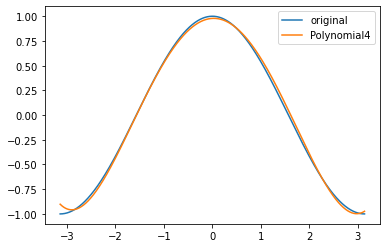

In [99]:
# 请利用matplotlib完成作图，画出余弦函数以及拟合的多项式函数在定义域内的图像
plt.plot(x, y, label="original")
plt.plot(x, model.forward(x).detach().numpy(), label="Polynomial4")
plt.legend()
plt.show()

# 3 基于卷积神经网络的图像分类(4')
本节我们将在FashionMINST数据集上完成简单的图像分类任务，对于网络的设计和最终的分类成绩本次作业没有确切的要求，不过如果稍微调一下参的话取得80%+的正确率应该不算难。

In [100]:
#数据下载，这里可以直接下现成的Dataset，如果同学们想更进一步学习的话应该了解torch.utils.data.Dataset类的写法
training_data = datasets.FashionMNIST(
    root="./", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(
    root="./", train=False, download=True, transform=ToTensor())

100.0%

Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw


111.0%

Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw


100.0%

Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw


159.1%d:\Anaconda3\envs\mypytorch\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw
Processing...
Done!


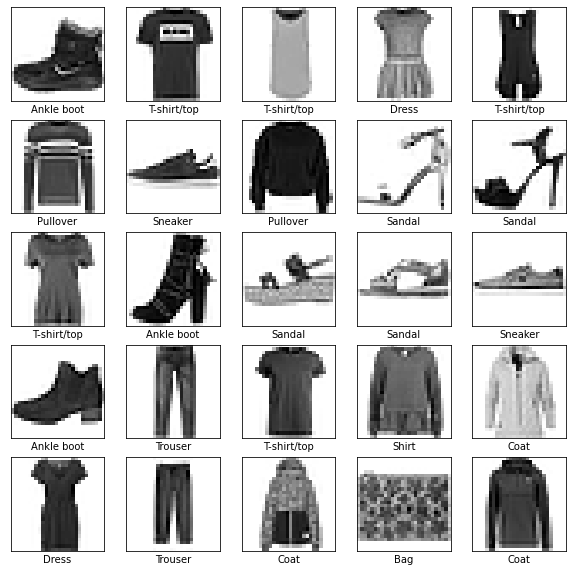

In [101]:
# 进行简单的可视化
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_data[i][0].squeeze(0), cmap=plt.cm.binary)
    plt.xlabel(labels[training_data[i][1]])
plt.show()

In [102]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [142]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #自行设计神经网络结构
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(5, 5)), # convolution kernel
            nn.BatchNorm2d(8), # batch normalization
            nn.ReLU(), # relu
            nn.MaxPool2d(kernel_size=(2, 2), stride=2), # maxpooling
            nn.Conv2d(8, 32, kernel_size=(3, 3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(32, 128, kernel_size=(5, 5)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.LogSoftmax(dim=-1) # softmax
        )
    
    def forward(self, x) :
        output = self.convnet(x)
        output = output.view(x.size(0), -1)
        output = self.fc(output)
        return output

In [161]:
def train_loop(dataloader, model, loss_fn, optimizer):
    cnt, totloss = 0, 0
    for batch, (image, label) in enumerate(dataloader):
        # TODO，训练函数
        optimizer.zero_grad()
        label_pred = model.forward(image)
        loss = loss_fn(label_pred, label)
        if batch % 100 == 0:
            print("{} / {} , loss: {:.6f}".format(batch*len(label), len(training_data), loss.item()))
            totloss += loss.item()
            cnt += 1
        loss.backward()
        optimizer.step()
    loss_list.append(totloss/cnt)

model = NeuralNetwork()
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.SGD(params=model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # learning rate schema

epochs = 30
loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    #TODO
    train_loop(train_dataloader, model, criterion, optimizer)

print("训练完成!")

Epoch 1
-------------------------------
0 / 60000 , loss: 2.308132
6400 / 60000 , loss: 1.505196
12800 / 60000 , loss: 0.920206
19200 / 60000 , loss: 0.912836
25600 / 60000 , loss: 0.714924
32000 / 60000 , loss: 0.644132
38400 / 60000 , loss: 0.569884
44800 / 60000 , loss: 0.622642
51200 / 60000 , loss: 0.556564
57600 / 60000 , loss: 0.479540
Epoch 2
-------------------------------
0 / 60000 , loss: 0.392711
6400 / 60000 , loss: 0.466306
12800 / 60000 , loss: 0.291011
19200 / 60000 , loss: 0.503853
25600 / 60000 , loss: 0.370251
32000 / 60000 , loss: 0.545215
38400 / 60000 , loss: 0.376657
44800 / 60000 , loss: 0.549673
51200 / 60000 , loss: 0.460618
57600 / 60000 , loss: 0.419416
Epoch 3
-------------------------------
0 / 60000 , loss: 0.269717
6400 / 60000 , loss: 0.336646
12800 / 60000 , loss: 0.227137
19200 / 60000 , loss: 0.435766
25600 / 60000 , loss: 0.287495
32000 / 60000 , loss: 0.488105
38400 / 60000 , loss: 0.303291
44800 / 60000 , loss: 0.460184
51200 / 60000 , loss: 0.388

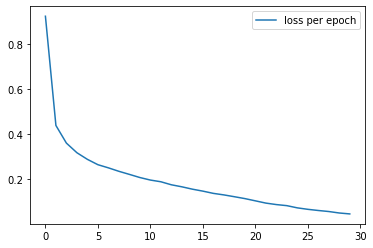

In [162]:
plt.plot(loss_list, label='loss per epoch')
plt.legend()
plt.show()

In [164]:
def test_loop(dataloader, model, loss_fn):
    with torch.no_grad():
        ans, cnt = 0, 0
        for image, label in dataloader:
        #TODO，测试函数
            label_pred = model(image).detach().numpy()
            ans += np.sum((np.argmax(label_pred, axis=1)==label.detach().numpy()))
            cnt += len(label)
        correct = ans / cnt
        print("Accuracy: {:.2f}%" .format(correct * 100))

test_loop(test_dataloader, model, criterion)

Accuracy: 89.19%
